# Import Libraries

In [2]:
# General purpose libraries
from scipy.io import loadmat
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# OS libraries
import os
import zipfile

# Signal processing libraries
from scipy import signal

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras import backend as K

# Warning libraries
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

colors_palette = ["#024059", "#0388A6", "#8C031C"] # Starting colors
sns.set_palette(sns.color_palette(colors_palette)) # Set colors for Seaborn
palette = sns.light_palette(colors_palette[0], as_cmap=True) # Palette

# Useful Functions

In [3]:
# Define the function to load the data
def load_data(f, type):
    data = loadmat(f)
    if type == 'ann':
        data = data['labels']
    elif type == 'spk':
        data = data['speaks']
    elif type == 'ppg':
        data = data['ppg']

    return data

In [4]:
# Allow each segment of the signal to be a shape suitable for the denoising autoencoder
def prepare_segments_for_autoencoder(signal, length=200):
    num_segments = len(signal) // length
    segments = [signal[i * length : (i + 1) * length] for i in range(num_segments)]
    segments = np.array(segments)  # Convert segments to a NumPy array
    segments = segments.reshape(-1, length, 1)  # Reshape for feeding into autoencoder (assuming 1 feature)
    return segments

# Load Data

In [7]:
# Insert path of files containing the signals
input_directory ='test_students'

print('Loading data...')

# Sort the files in the folder wrt the name
os.listdir(input_directory).sort()


annotations_files = []
spk_files = []
ppg_files = []
sampling_frequencies = []

# Get name of header files contained in the folder
for f in os.listdir(input_directory):
    g = os.path.join(input_directory, f)

    print(g)

    # Extract the first 4 chars of the file name
    chars = g[7 + 8:10 + 8]
    print(chars)
    idx = int(chars)
    print(idx)

    if '_ann' in g:
        annotations_files.append({'idx': idx, 'annot': g})
    elif '_spk' in g:
        spk_files.append({'idx': idx, 'spk': g})
    else:
        ppg_files.append({'idx': idx, 'ppg': g})
        # Save the sampling frequency of the signal only one time
        if '128' in g:
            sampling_frequencies.append(128)
        elif '250' in g:
            sampling_frequencies.append(250)

# Get dataframes from lists
#annotations_files = pd.DataFrame(annotations_files)
spk_files = pd.DataFrame(spk_files)
ppg_files = pd.DataFrame(ppg_files)

# Sort dataframes wrt the index
#annotations_files = annotations_files.sort_values(by=['idx'])
spk_files = spk_files.sort_values(by=['idx'])
ppg_files = ppg_files.sort_values(by=['idx'])

# Create empty list for data
annotations = []
spk = []
ppg = []

# Load data into variables
"""
for a in annotations_files['annot']:
    annotation = load_data(a, type='ann')
    annotation = np.array(annotation)
    annotations.append(annotation)
"""
for a in spk_files['spk']:
    spk_data = load_data(a, type='spk')
    spk_data = np.array(spk_data)
    spk.append(spk_data)
    # transform to array the spk data

for a in ppg_files['ppg']:
    ppg_data = load_data(a, type='ppg')
    ppg_data = np.array(ppg_data)
    ppg.append(ppg_data)

print('Done')



Loading data...


FileNotFoundError: [Errno 2] No such file or directory: 'test_students'

In [ ]:
del spk_files, ppg_files

In [ ]:
del spk_data

## Plot Data

In [ ]:
def plot_signal_with_annotations(plot_length, signal_ppg, beat_peaks, sampling_fs, beat_annot=None):
    # Calculate time axis based on sample frequency
    time = np.arange(plot_length) / sampling_fs

    # Set the Seaborn style
    sns.set(style="darkgrid")

    # Create a Seaborn plot
    plt.figure(figsize=(10, 6))

    # Plot the normalized PPG signal using matplotlib's plt.plot
    plt.plot(time, signal_ppg[:plot_length], color=colors_palette[0], label='PPG Signal')

    # Annotate each peak with the corresponding annotation using Seaborn scatter plot
    """
    for i in range(beat_peaks.shape[0]):
        if beat_peaks[i] < plot_length and beat_annot[i] != 'N':
            plt.text(time[beat_peaks[i]], signal_ppg[beat_peaks[i]], beat_annot[i],
                     ha='center', va='bottom', color='black')
            plt.scatter(time[beat_peaks[i]], signal_ppg[beat_peaks[i]], color='black', marker='o', s=10)
    """
    # Set plot labels and title
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('PPG Signal')

    # Display the grid
    plt.grid(True)

    # Show the legend
    plt.legend()

    # Show the Seaborn plot
    #plt.show()
    plt.tight_layout()
    plt.savefig("plots/Signal.png", dpi=300)


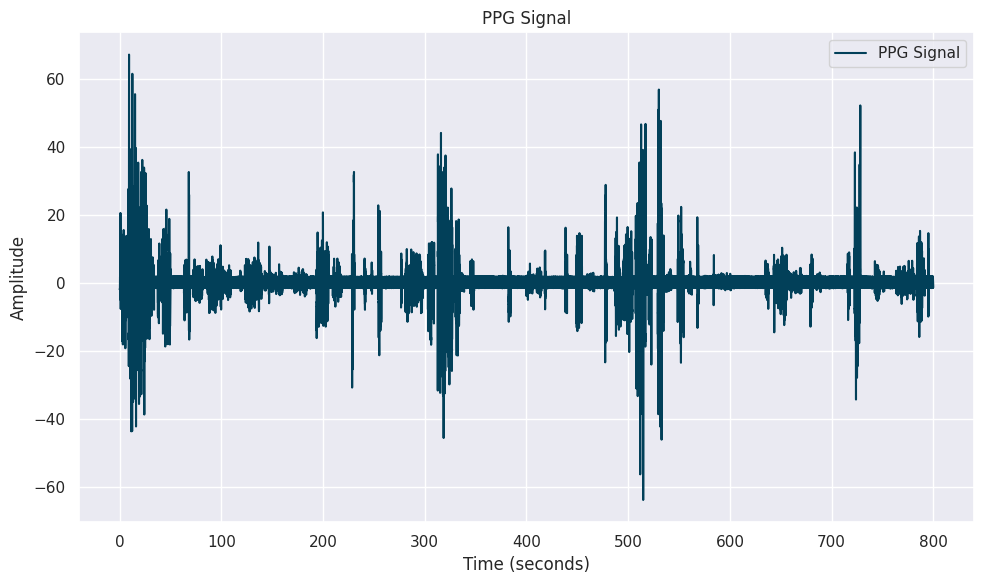

In [ ]:
# select the ppg to be plotted
patient = 13

# Get the signal, peaks and annotations
signal_temp = ppg[patient]
peaks = spk[patient]
#annot = annotations[patient]
fs = 250

# Define the length of the plot
plot_len = 200000

# Plot the signal with annotations
plot_signal_with_annotations(plot_len, signal_temp, peaks, sampling_fs = fs)

## Get Data Insight

In [ ]:
signal_len_128 = []
for i in range(10):
  signal_len_128.append(len(ppg[i]))
print(f'The average length for signals sampled at 128 Hz is {np.mean(signal_len_128)}')

The average length for signals sampled at 128 Hz is 10367554.3


In [ ]:
signal_len_250 = []
for i in range(62, 105):
  signal_len_250.append(len(ppg[i]))
print(f'The average length for signals sampled at 250 Hz is {np.mean(signal_len_250)}')

In [ ]:
normal_128 = 0
abnormal_128 = 0
total_128 = 0

for i in range(62):
  unique, count = np.unique(annotations[i], return_counts = True)

  normal_128 += count[0]
  if count.shape[0] > 1:
      abnormal_128 += count[1]
      if count.shape[0] >2:
          abnormal_128 += count[2]

print(f'Number of normal beats for signals sampled at 128 hz: {normal_128}')
print(f'Number of abnormal beats for signals sampled at 128 hz: {abnormal_128}')


In [ ]:
normal_250 = 0
abnormal_250 = 0
total_250 = 0

for i in range(62, 105):
  unique, count = np.unique(annotations[i], return_counts = True)

  normal_250 += count[0]
  if count.shape[0] > 1:
      abnormal_250 += count[1]
      if count.shape[0] >2:
          abnormal_250 += count[2]

print(f'Number of normal beats for signals sampled at 250 hz: {normal_250}')
print(f'Number of abnormal beats for signals sampled at 250 hz: {abnormal_250}')

In [ ]:
total = normal_250 + abnormal_250 +normal_128 + abnormal_128
print(f'Percentage of normal beats for signals sampled at 128 hz: {round(normal_128/total*100, 2)}%')
print(f'Percentage of abnormal beats for signals sampled at 128 hz: {round(abnormal_128/total*100, 2)}%')
print(f'Percentage of normal beats for signals sampled at 250 hz: {round(normal_250/total*100, 2)}%')
print(f'Percentage of abnormal beats for signals sampled at 250 hz: {round(abnormal_250/total*100, 2)}%')

In [ ]:
V_128 = 0
S_128 = 0
for i in range(62):
  for j in annotations[i]:
    if j == 'V':
      V_128 += 1
    elif j == 'S':
      S_128 += 1
print(f'Number of ventricular beats for signals sampled at 128 hz: {V_128}')
print(f'Number of sopraventricular beats for signals sampled at 128 hz: {S_128}')
print(f'Percentage of ventricular beats for signals sampled at 128 hz: {round(V_128/total*100, 2)}%')
print(f'Percentage of sopraventricular beats for signals sampled at 128 hz: {round(S_128/total*100, 2)}%')

In [ ]:
V_250 = 0
S_250 = 0
for i in range(62, 105):
  for j in annotations[i]:
    if j == 'V':
      V_250 += 1
    elif j == 'S':
      S_250 += 1
print(f'Number of ventricular beats for signals sampled at 250 hz: {V_250}')
print(f'Number of sopraventricular beats for signals sampled at 250 hz: {S_250}')
print(f'Percentage of ventricular beats for signals sampled at 250 hz: {round(V_250/total*100, 2)}%')
print(f'Percentage of sopraventricular beats for signals sampled at 250 hz: {round(S_250/total*100, 2)}%')

# Denoising Autoencoder

In [ ]:
# Load the model
model = tfk.models.load_model('DenoisingAutoencoder')

In [ ]:
ppg_segments = prepare_segments_for_autoencoder(ppg[0])

In [ ]:
# Make the predictions
predictions = model.predict(ppg_segments)

In [ ]:
# Compute the mean MSE for each segment
mse = np.square(ppg_segments - predictions)
means_mse = [sum(subvector) / len(subvector) if len(subvector) > 0 else float('nan') for subvector in mse]

In [ ]:
# Build the MSE vector in the range of the signal, replicating each MSE 200 times
mse_vector = [value for value in means_mse for _ in range(200)]

In [ ]:
# Plot the signal ant the computed mse
plt.figure(figsize=(8, 6))
plt.plot(ppg[0][0:25000], label='Signal')
plt.plot(mse_vector[:25000], label='MSE Vector')
# plt.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='y=3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Signal vs MSE Vector')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Perform the same operation for each signal in the dataset
# and build a dataframe with the mean MSEs for each signal

mse_signals = []
for signal in ppg:
  test_ppg = signal

  # prepare the segments to be fed to the denoising autoencoder
  ppg_segments = prepare_segments_for_autoencoder(test_ppg)

  # Make the predictions
  predictions = model.predict(ppg_segments)

  # Compute the mean MSE for each segment
  mse = np.square(ppg_segments - predictions)

  mse_error = [np.mean(error) for error in mse]

  mse_signals.append(mse_error)



In [ ]:
# build the cleaned dataset
ppg_cleaned = []
annotations_cleaned = []

for i in range(len(ppg)):
    # Get the ith signal
    signal = ppg[i]

    # Get the MSEs for the ith signal

    mse_i = [x for x in mse_signals[i] for _ in range(200)]

    signal_cleaned = signal.copy()
    # set to zeros the pieces for which the mse is >= 3
    for j in range(len(mse_i)):
      if mse_i[j] > 1.5:
        signal_cleaned[j] = 0


    # Add the cleaned signal to the list
    ppg_cleaned.append(signal_cleaned)

In [ ]:
# Since some artifacts are still present, set to zero the values which are greather than the mean of the signal
for signal in ppg_cleaned:
  for i in range(len(signal)):
    if signal[i] > 2.5 or signal[i] < -2.5:
      signal[i] = 0

In [ ]:
# Plot the signal ant the computed mse
plt.figure(figsize=(18, 6))
plt.plot(ppg[100][:100000], label='Signal')
plt.plot(ppg_cleaned[100][:100000], label='Signal')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Signal vs MSE Vector')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(np.unique(sampling_frequencies, return_counts = True))

In [ ]:
ppg_cleaned_copy = ppg_cleaned
for i in range(len(ppg_cleaned_copy)):
  ppg_cleaned_copy[i] = ppg_cleaned_copy[i].flatten()

In [ ]:
ppg_cleaned_128 = pd.DataFrame(ppg_cleaned_copy[:62])

In [ ]:
ppg_cleaned_250 = pd.DataFrame(ppg_cleaned_copy[62:])

In [ ]:
ppg_cleaned_128.to_csv('ppg_cleaned_128.csv', index=False)
ppg_cleaned_250.to_csv('ppg_cleaned_250.csv', index=False)

# Autoencoder 128

In [ ]:
# Load the model
model = tfk.models.load_model('./Project_Cesani_Fervari_Zanette - Models & Datasets/Autoencoder128')

In [ ]:
ppg_segments = prepare_segments_for_autoencoder(ppg[3])

In [ ]:
# Make the predictions
predictions = model.predict(ppg_segments)

36/36 [==============================] - 3s 8ms/step


In [ ]:
# Compute the mean MSE for each segment
mse = np.square(ppg_segments - predictions)
means_mse = [np.mean(error) for error in mse]

In [ ]:
# Build the MSE vector in the range of the signal, replicating each MSE 200 times
mse_vector = [value for value in means_mse for _ in range(200)]

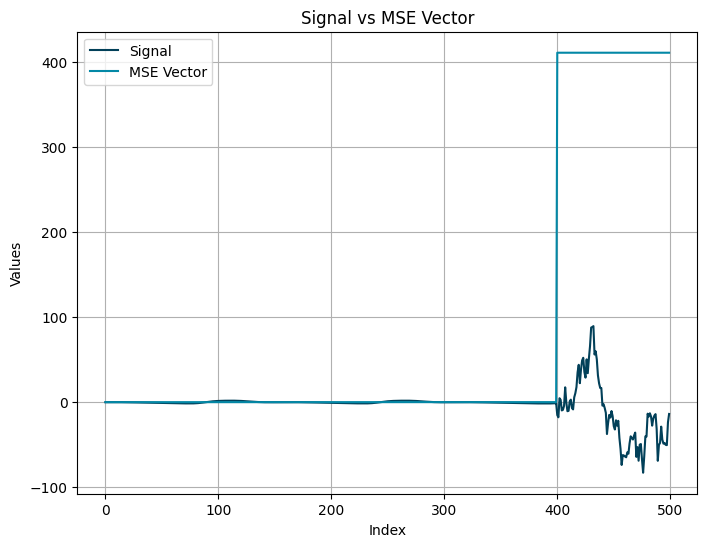

In [ ]:
# Plot the signal ant the computed mse
plt.figure(figsize=(8, 6))
plt.plot(ppg[3][1000:1500], label='Signal')
plt.plot(mse_vector[1000:1500], label='MSE Vector')
# plt.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='y=3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Signal vs MSE Vector')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Perform the same operation for each signal in the dataset
# and build a dataframe with the mean MSEs for each signal

mse_signals = []
for signal in ppg[:16]:

  # prepare the segments to be fed to the denoising autoencoder
  ppg_segments = prepare_segments_for_autoencoder(signal)

  # Make the predictions
  predictions = model.predict(ppg_segments)

  # Compute the mean MSE for each segment
  mse = np.square(ppg_segments - predictions)

  mse_error = [np.mean(error) for error in mse]

  mse_signals.append(mse_error)



36/36 [==============================] - 0s 2ms/step


In [ ]:
# build the cleaned dataset
ppg_cleaned_128 = []

for i in range(len(ppg[:16])):
    # Get the ith signal
    signal = ppg[i]

    # Get the MSEs for the ith signal

    mse_i = [x for x in mse_signals[i] for _ in range(200)]

    signal_cleaned = signal.copy()
    # set to zeros the pieces for which the mse is >= 3
    for j in range(len(mse_i)):
      if mse_i[j] > 0.5:
        signal_cleaned[j] = 0


    # Add the cleaned signal to the list
    ppg_cleaned_128.append(signal_cleaned)

In [ ]:
def plot_signal_with_annotations_2(start_plot, end_plot, signal_ppg, beat_peaks, sampling_fs, beat_annot = None):
    # Calculate time axis based on sample frequency
    time = np.arange(len(signal_ppg)) / sampling_fs

    # Plotting the selected slice of the normalized PPG signal
    plt.figure(figsize=(10, 6))

    # Annotating each peak with the corresponding annotation within the selected slice
    """
    for i in range(len(beat_peaks)):
        if start_plot <= beat_peaks[i] < end_plot and beat_annot[i] != 'N':
            # Plot the annotations
            plt.text(time[beat_peaks[i]], signal_ppg[beat_peaks[i]], beat_annot[i],
                     ha='center', va='bottom', color='black')
            plt.scatter(time[beat_peaks[i]], signal_ppg[beat_peaks[i]], color='black', marker='o', s=10)
    """
    plt.plot(time[start_plot:end_plot], signal_ppg[start_plot:end_plot], label='Normalized PPG Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'PPG Signal with Peak Annotations (Slice from {start_plot} to {end_plot} Steps)')
    plt.legend()
    plt.grid(True)
    plt.show()


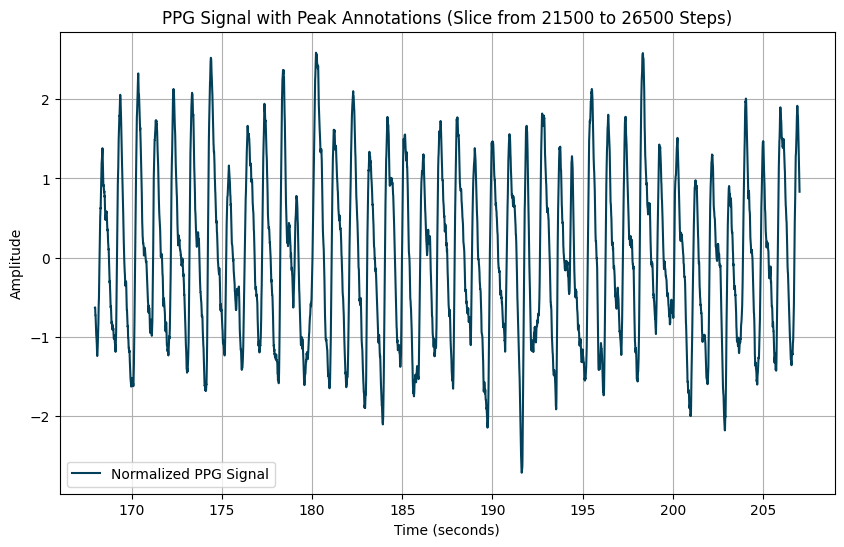

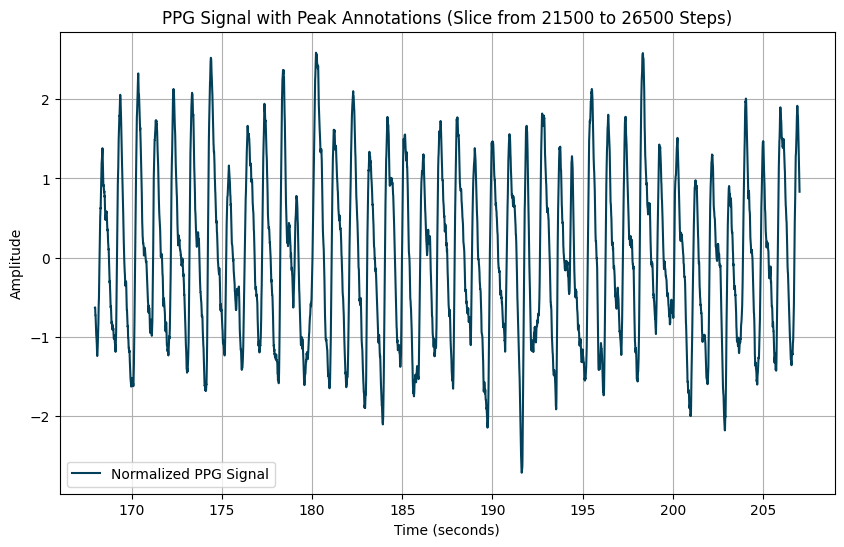

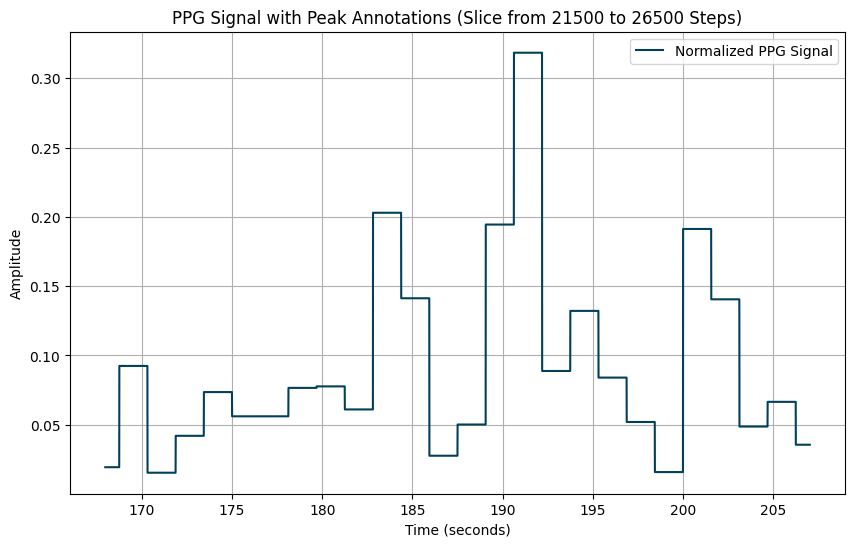

In [ ]:
# select the ppg to be plotted
patient = 15

# Get the signal, peaks and annotations
signal_temp_cleaned = ppg_cleaned_128[patient]
signal_temp = ppg[patient]
mse_i = [x for x in mse_signals[patient] for _ in range(200)]
peaks = spk[patient]
fs = 128

# Plot the signal with annotations
plot_signal_with_annotations_2(21500, 26500, signal_temp_cleaned, peaks, sampling_fs = fs)
plot_signal_with_annotations_2(21500, 26500, signal_temp, peaks, sampling_fs = fs)
plot_signal_with_annotations_2(21500, 26500, np.array(mse_i), peaks, sampling_fs = fs)

In [ ]:
# Plot the signal ant the computed mse
plt.figure(figsize=(18, 6))
plt.plot(ppg[50][:250000], label='Signal')
plt.plot(ppg_cleaned[50][:250000], label='Signal Cleaned')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Signal vs MSE Vector')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(np.unique(sampling_frequencies, return_counts = True))

In [ ]:
ppg_cleaned_copy_128 = ppg_cleaned_128
for i in range(len(ppg_cleaned_copy_128)):
  ppg_cleaned_copy_128[i] = ppg_cleaned_copy_128[i].flatten()

In [ ]:
ppg_cleaned_128 = pd.DataFrame(ppg_cleaned_copy_128[:16])

In [ ]:
ppg_cleaned_128.to_csv('ppg_cleaned_128_test.csv', index=False)


# Autoencoder 250

In [ ]:
# Load the model
model = tfk.models.load_model('./Project_Cesani_Fervari_Zanette - Models & Datasets/Autoencoder250')

In [ ]:
ppg_segments = prepare_segments_for_autoencoder(ppg[17])

In [ ]:
# Make the predictions
predictions = model.predict(ppg_segments)

3163/3163 [==============================] - 7s 2ms/step


In [ ]:
# Compute the mean MSE for each segment
mse = np.square(ppg_segments - predictions)
means_mse = [np.mean(error) for error in mse]

In [ ]:
# Build the MSE vector in the range of the signal, replicating each MSE 200 times
mse_vector = [value for value in means_mse for _ in range(200)]

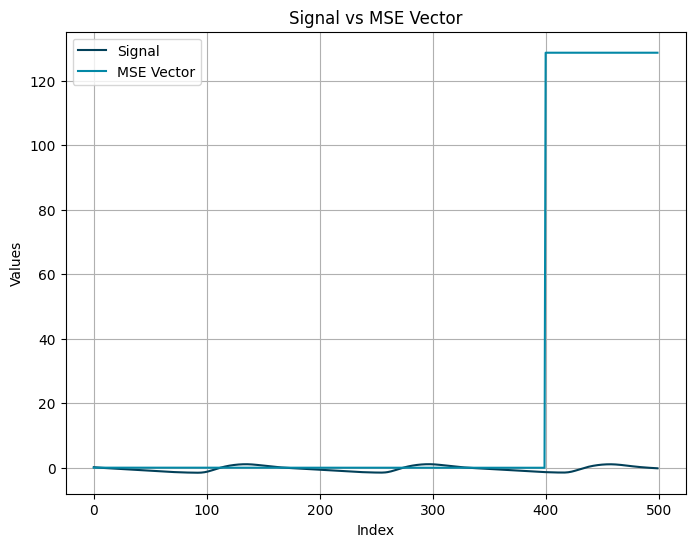

In [ ]:
# Plot the signal ant the computed mse
plt.figure(figsize=(8, 6))
plt.plot(ppg[17][1000:1500], label='Signal')
plt.plot(mse_vector[1000:1500], label='MSE Vector')
# plt.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='y=3')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Signal vs MSE Vector')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Perform the same operation for each signal in the dataset
# and build a dataframe with the mean MSEs for each signal

mse_signals = []
for signal in ppg[16:21]:

  # prepare the segments to be fed to the denoising autoencoder
  ppg_segments = prepare_segments_for_autoencoder(signal)

  # Make the predictions
  predictions = model.predict(ppg_segments)

  # Compute the mean MSE for each segment
  mse = np.square(ppg_segments - predictions)

  mse_error = [np.mean(error) for error in mse]

  mse_signals.append(mse_error)



3237/3237 [==============================] - 7s 2ms/step


In [ ]:
# build the cleaned dataset
ppg_cleaned_250 = []

for i in range(len(ppg[16:21])):
    # Get the ith signal
    signal = ppg[i+16]

    # Get the MSEs for the ith signal

    mse_i = [x for x in mse_signals[i] for _ in range(200)]

    signal_cleaned = signal.copy()
    # set to zeros the pieces for which the mse is >= 3
    for j in range(len(mse_i)):
      if j < len(signal):
        if mse_i[j] > 0.5:
          signal_cleaned[j] = 0


    # Add the cleaned signal to the list
    ppg_cleaned_250.append(signal_cleaned.flatten())

In [ ]:
del mse, ppg, model

In [ ]:
del ppg_data, predictions, signal, signal_cleaned, ppg_segments, mse_i, mse_signals

In [ ]:
def plot_signal_with_annotations_2(start_plot, end_plot, signal_ppg, beat_peaks, beat_annot, sampling_fs):
    # Calculate time axis based on sample frequency
    time = np.arange(len(signal_ppg)) / sampling_fs

    # Plotting the selected slice of the normalized PPG signal
    plt.figure(figsize=(10, 6))

    # Annotating each peak with the corresponding annotation within the selected slice
    for i in range(len(beat_peaks)):
        if start_plot <= beat_peaks[i] < end_plot and beat_annot[i] != 'N':
            # Plot the annotations
            plt.text(time[beat_peaks[i]], signal_ppg[beat_peaks[i]], beat_annot[i],
                     ha='center', va='bottom', color='black')
            plt.scatter(time[beat_peaks[i]], signal_ppg[beat_peaks[i]], color='black', marker='o', s=10)

    plt.plot(time[start_plot:end_plot], signal_ppg[start_plot:end_plot], label='Normalized PPG Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Amplitude')
    plt.title(f'Normalized PPG Signal with Peak Annotations (Slice from {start_plot} to {end_plot} Steps)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# select the ppg to be plotted
patient = 27

# Get the signal, peaks and annotations
signal_temp_cleaned = ppg_cleaned[patient]
signal_temp = ppg[patient + 62]
mse_i = [x for x in mse_signals[patient] for _ in range(200)]
peaks = spk[patient + 62]
annot = annotations[patient + 62]
fs = 250

# Define the length of the plot
plot_len = 100000

# Plot the signal with annotations
plot_signal_with_annotations_2(51500, 56500, signal_temp_cleaned, peaks, annot, fs)
plot_signal_with_annotations_2(51500, 56500, signal_temp, peaks, annot, fs)
plot_signal_with_annotations_2(51500, 56500, np.array(mse_i), peaks, annot, fs)

In [ ]:
# Plot the signal ant the computed mse
plt.figure(figsize=(18, 6))
plt.plot(ppg[62][:20000], label='Signal')
plt.plot(ppg_cleaned[0][:20000], label='Signal Cleaned')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Signal vs MSE Vector')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(np.unique(sampling_frequencies, return_counts = True))

In [ ]:
ppg_cleaned_copy_250 = ppg_cleaned_250
for i in range(len(ppg_cleaned_copy_250)):
  ppg_cleaned_copy_250[i] = ppg_cleaned_copy_250[i].flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [ ]:
ppg_cleaned_250 = pd.DataFrame(ppg_cleaned_250)

In [ ]:
ppg_cleaned_250.to_csv('ppg_cleaned_250_test_1.csv', index=False)

# Peak Distances

In [ ]:
peak_distances = []
for i in range(len(spk)):
  peak_distances.append(np.mean(spk[i][1:] - spk[i][:-1]))

In [ ]:
plt.plot(peak_distances)
plt.axvline(62, c = 'red')
plt.hlines(np.median(peak_distances[:62]), xmin = 0, xmax = 62, colors = 'green')
plt.hlines(np.median(peak_distances[62:]), xmin = 62, xmax = 105, colors = 'green')

In [ ]:
np.argmax(peak_distances)

In [ ]:
np.argmin(peak_distances)

In [ ]:
# Plot one signal
idx = 32
sample_frequency = 128 # Hz
time_values = np.arange(len(ppg[idx]))
# Plot the signal
plt.plot(time_values, ppg[idx])
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Amplitude')
plt.title('Signal Plot')
plt.grid(True)
plt.xlim(spk[idx][8] - np.median(peak_distances[:62]), spk[idx][8] + np.median(peak_distances[:62]))
plt.ylim(-2, 2)
plt.show()